In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.express as px
from bayes_opt import BayesianOptimization

In [2]:
# SPDR ETFs
assets = [
    'XLC',  # Communication Services
    'XLY',  # Consumer Discretionary
    'XLP',  # Consumer Staples
    'XLE',  # Energy
    'XLF',  # Financials
    'XLV',  # Health Care
    'XLI',  # Industrials
    'XLB',  # Materials
    'XLRE', # Real Estate
    'XLK',  # Technology
    'XLU',  # Utilities
    'SPY',  # S&P 500
]

# Download data from Yahoo Finance since 2018-06-19 (when all ETFs are available)
start = '2018-06-19'
data = {}
for ticker in assets:
    data[ticker] = yf.download(ticker, start=start)

# Calculate daily returns
returns = pd.DataFrame()
for ticker in assets:
    returns[ticker] = data[ticker]['Adj Close'].pct_change().iloc[1:]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [3]:
def MA_strategy(asset_returns, lower_period, upper_period):
    '''
    asset_returns: dataframe with the returns of a single asset
    lower_period: lower moving average period
    upper_period: upper moving average period

    Returns the strategy's performance
    '''
    num_periods = len(asset_returns)
    weights = []
    for i in range(upper_period, num_periods):
        lower_ma = (asset_returns.iloc[i-lower_period:i-1]+1).cumprod().iloc[0]
        upper_ma = (asset_returns.iloc[i-upper_period:i-1]+1).cumprod().iloc[0]
        diff = lower_ma - upper_ma
        if diff > 0:
            weights.append(1)
        else:
            weights.append(0)
    result = asset_returns[upper_period:].copy()
    result['Weight'] = weights
    result['Return'] = result['Weight'] * asset_returns[upper_period:]
    mean = result['Return'].mean() * 252
    std = result['Return'].std() * np.sqrt(252)
    sharpe = mean/std
    return result, mean, std, sharpe

In [4]:
# Perform Bayesian optimization
def MA_objective(lower_period, upper_period):
    lower_period = int(lower_period)
    upper_period = int(upper_period)
    if upper_period <= lower_period:
        return -1
    sharpe = MA_strategy(returns['SPY'], lower_period, upper_period)[3]
    return sharpe

pbounds = {
    'lower_period': (2, 100),
    'upper_period': (50, 250)
}

optimizer = BayesianOptimization(MA_objective, pbounds, random_state=1)
optimizer.maximize(init_points=20, n_iter=100)
print(optimizer.max)

|   iter    |  target   | lower_... | upper_... |
-------------------------------------------------
| 1         | 1.092     | 42.87     | 194.1     |
| 2         | 0.2956    | 2.011     | 110.5     |
| 3         | 0.4002    | 16.38     | 68.47     |
| 4         | 0.3751    | 20.25     | 119.1     |
| 5         | 0.5325    | 40.88     | 157.8     |
| 6         | -0.1907   | 43.08     | 187.0     |
| 7         | -0.2706   | 22.04     | 225.6     |
| 8         | 0.4227    | 4.684     | 184.1     |
| 9         | 1.14      | 42.9      | 161.7     |
| 10        | 0.3419    | 15.76     | 89.62     |
| 11        | 0.5219    | 80.47     | 243.7     |
| 12        | 0.2928    | 32.72     | 188.5     |
| 13        | 1.093     | 87.89     | 228.9     |
| 14        | 0.1733    | 10.33     | 57.81     |
| 15        | 0.6603    | 18.64     | 225.6     |
| 16        | 0.2445    | 11.64     | 134.2     |
| 17        | 0.4395    | 95.87     | 156.6     |
| 18        | 0.5516    | 69.8      | 113.1     |


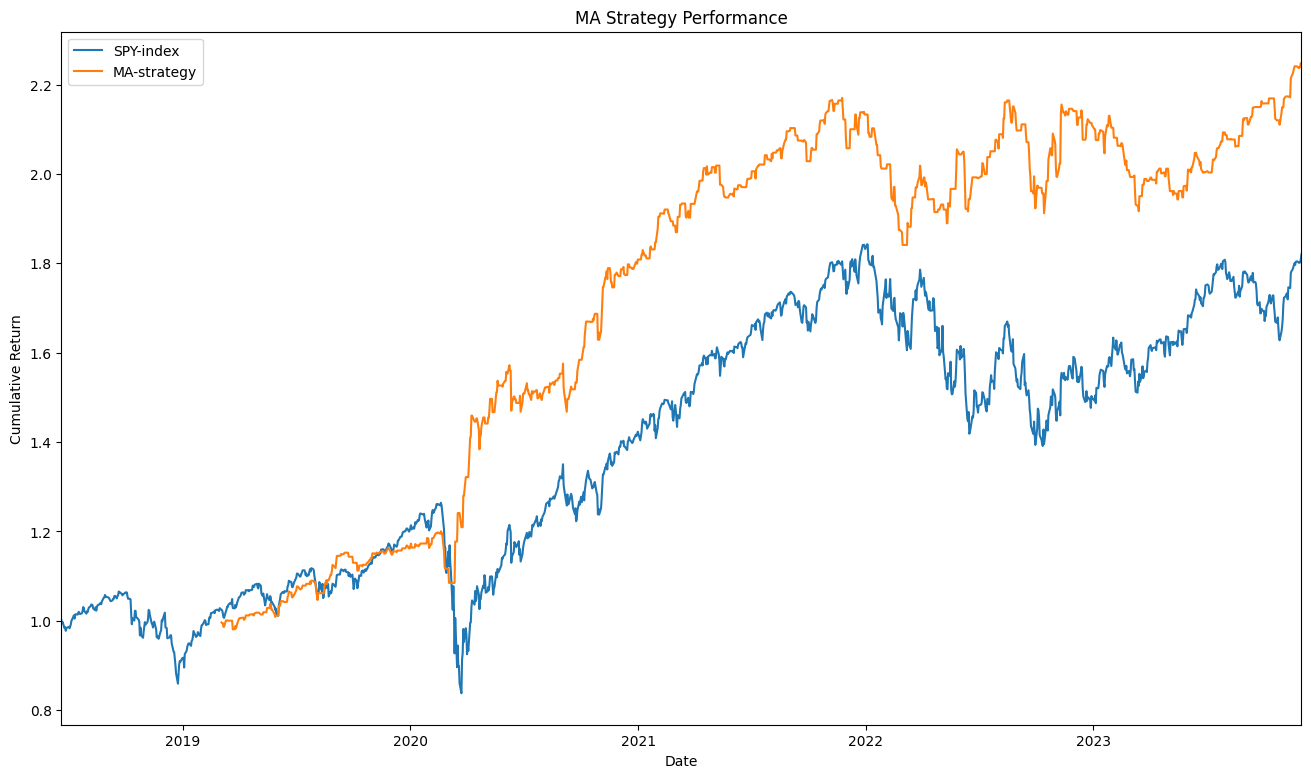

In [5]:
lower_period = int(optimizer.max['params']['lower_period'])
upper_period = int(optimizer.max['params']['upper_period'])
optimal_strat = MA_strategy(returns['SPY'], lower_period, upper_period)[0]

# Plot strategy performance
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot((returns['SPY']+1).cumprod(), label='SPY-index')
ax.plot((optimal_strat['Return']+1).cumprod(), label='MA-strategy')
ax.legend()
ax.set_title('MA Strategy Performance')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Return')
ax.margins(x=0)
plt.show()

In [6]:
# Try other assets
strats = {}
for i in assets:
    strats[i] = MA_strategy(returns[i], lower_period, upper_period)[0]

fig = px.line()
fig.add_scatter(x=returns['SPY'].index, y=(returns['SPY']+1).cumprod(), name='SPY-index')
for i in assets:
    fig.add_scatter(x=strats[i].index, y=(strats[i]['Return']+1).cumprod(), name=i)
fig.update_layout(title='MA Strategy Performance', xaxis_title='Date', yaxis_title='Cumulative Return')
fig.show()

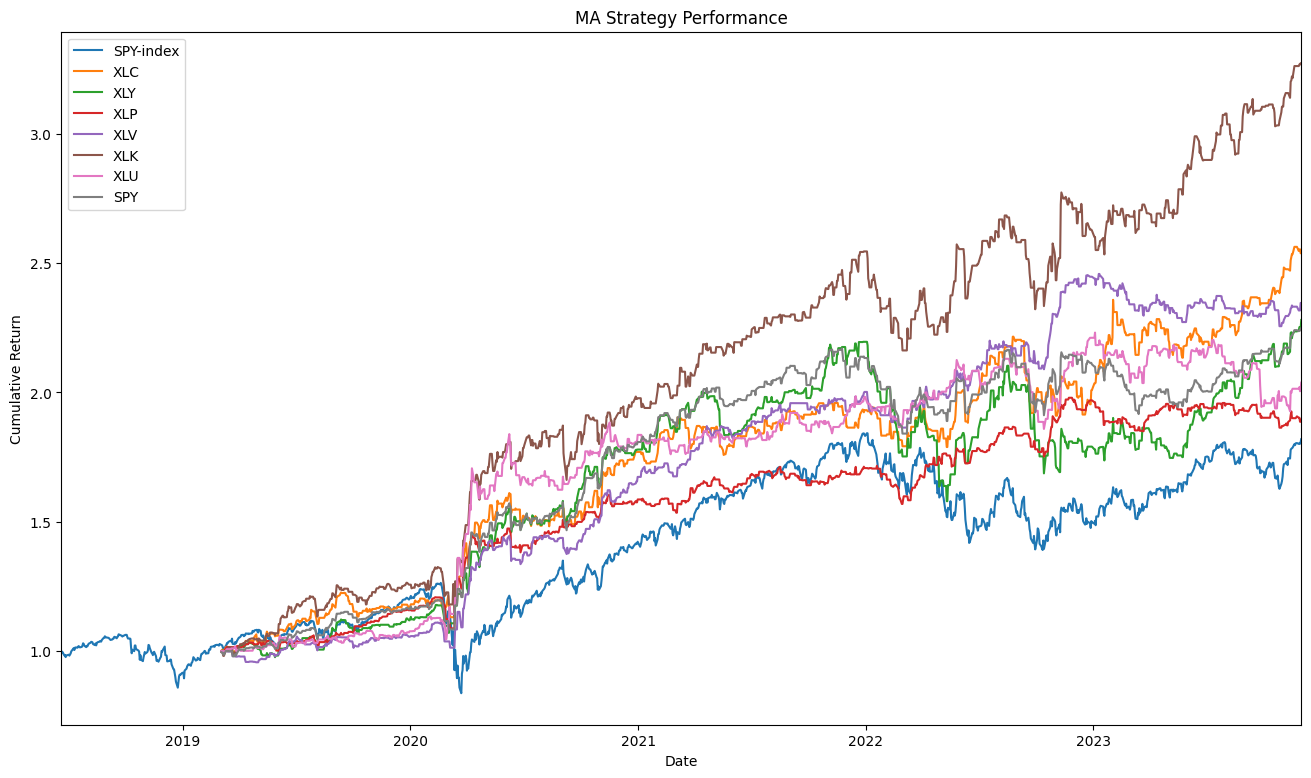

In [7]:
# 7/12 strategies performed better than SPY with the same parameters (9 and 175)
selected_assets = [
    'XLC',
    'XLY',
    'XLP',
    'XLV',
    'XLK',
    'XLU',
    'SPY'
]

fig, ax = plt.subplots(figsize=(16, 9))
ax.plot((returns['SPY']+1).cumprod(), label='SPY-index')
for i in selected_assets:
    ax.plot((strats[i]['Return']+1).cumprod(), label=i)
ax.legend()
ax.set_title('MA Strategy Performance')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Return')
ax.margins(x=0)
plt.show()